In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data/combined_data.csv')
data.head()

,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,...,windBearing,cloudCover,uvIndex,visibility,precipType,ozone,precipAccumulation,city,timestamp,demand_mwh
0,Clear,clear-night,0.0,0.0,89.56,91.71,65.31,0.45,1011.9,10.84,...,164.0,0.06,0.0,9.617,NaN,NaN,NaN,dallas,2018-07-02 05:00:00,NaN
1,Clear,clear-night,0.0,0.0,89.56,91.71,65.31,0.45,1011.9,10.84,...,164.0,0.06,0.0,9.617,NaN,NaN,NaN,dallas,2018-07-02 05:00:00,13839.7
2,Clear,clear-night,0.0,0.0,89.56,91.71,65.31,0.45,1011.9,10.84,...,164.0,0.06,0.0,9.617,NaN,NaN,NaN,dallas,2018-07-02 05:00:00,13839.7
3,Clear,clear-night,0.0,0.0,89.56,91.71,65.31,0.45,1011.9,10.84,...,164.0,0.06,0.0,9.617,NaN,NaN,NaN,dallas,2018-07-02 05:00:00,13839.7
4,Clear,clear-night,0.0,0.0,88.35,92.26,68.29,0.52,1012.7,9.94,...,179.0,0.04,0.0,9.817,NaN,NaN,NaN,dallas,2018-07-02 06:00:00,NaN


In [4]:
print(data.shape)
data.info()

(342018, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342018 entries, 0 to 342017
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   summary              341469 non-null  object 
 1   icon                 341461 non-null  object 
 2   precipIntensity      341562 non-null  float64
 3   precipProbability    341562 non-null  float64
 4   temperature          341997 non-null  float64
 5   apparentTemperature  341997 non-null  float64
 6   dewPoint             342018 non-null  float64
 7   humidity             341997 non-null  float64
 8   pressure             341901 non-null  float64
 9   windSpeed            341913 non-null  float64
 10  windGust             341566 non-null  float64
 11  windBearing          341905 non-null  float64
 12  cloudCover           341532 non-null  float64
 13  uvIndex              341671 non-null  float64
 14  visibility           341680 non-null  float64
 15  prec

In [5]:
# Dropping duplicate rows
print("Data Shape before dropping duplicates:", data.shape)
data = data.sort_values(['timestamp', 'city', 'demand_mwh'], na_position='first')
data.drop_duplicates(subset=['timestamp', 'city'], keep='last', inplace=True)
data.reset_index(drop=True, inplace=True)
print("Data Shape after dropping duplicates:", data.shape)

Data Shape before dropping duplicates: (342018, 21)
Data Shape after dropping duplicates: (165740, 21)


In [6]:
# Collecting the columns of interest only
cols = ['timestamp','city','temperature','humidity','windSpeed', 'pressure', 'dewPoint', 'demand_mwh']
avail = [c for c in cols if c in data.columns]
data = data[avail]
print("Data Shape after filtering columns:", data.shape)

Data Shape after filtering columns: (165740, 8)


In [7]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
timestamp      0.000000
city           0.000000
temperature    0.006034
humidity       0.006034
windSpeed      0.031978
pressure       0.030168
dewPoint       0.000000
demand_mwh     2.923253
dtype: float64


In [8]:
# Approx 3% data is null so drop the rows with null values
data.dropna(inplace=True)
print("Data Shape after dropping null values:", data.shape)

Data Shape after dropping null values: (160804, 8)


In [9]:
data.isna().sum()

timestamp      0
city           0
temperature    0
humidity       0
windSpeed      0
pressure       0
dewPoint       0
demand_mwh     0
dtype: int64

In [10]:
data.dtypes

timestamp       object
city            object
temperature    float64
humidity       float64
windSpeed      float64
pressure       float64
dewPoint       float64
demand_mwh     float64
dtype: object

In [11]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp']

0        2018-07-01 07:00:00
1        2018-07-01 07:00:00
2        2018-07-01 07:00:00
3        2018-07-01 07:00:00
4        2018-07-01 07:00:00
                 ...        
165080   2020-05-19 23:00:00
165084   2020-05-20 00:00:00
165085   2020-05-20 00:00:00
165089   2020-05-20 00:00:00
165090   2020-05-20 00:00:00
Name: timestamp, Length: 160804, dtype: datetime64[ns]

Preprocessing

In [12]:
# Extract hour, day of week, and month, season from the timestamp
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data['season'] = data['timestamp'].dt.month % 12 // 3 + 1
data['season'] = data['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
data['season'] = data['season'].astype('category')

In [13]:
data.head()

,timestamp,city,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour,day_of_week,month,season
0,2018-07-01 07:00:00,la,65.45,0.79,4.23,1014.5,58.64,9353.0,7,6,7,Summer
1,2018-07-01 07:00:00,phoenix,86.82,0.16,4.30,1008.9,34.57,2764.0,7,6,7,Summer
2,2018-07-01 07:00:00,san diego,61.71,0.80,3.53,1015.9,55.47,1737.0,7,6,7,Summer
3,2018-07-01 07:00:00,san jose,67.78,0.60,6.36,1012.8,53.27,10653.0,7,6,7,Summer
4,2018-07-01 07:00:00,seattle,59.32,0.86,4.81,1022.1,55.21,774.0,7,6,7,Summer


In [14]:
data.set_index('timestamp', inplace=True)
data.head()

,city,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour,day_of_week,month,season
timestamp,,,,,,,,,,,
2018-07-01 07:00:00,la,65.45,0.79,4.23,1014.5,58.64,9353.0,7,6,7,Summer
2018-07-01 07:00:00,phoenix,86.82,0.16,4.30,1008.9,34.57,2764.0,7,6,7,Summer
2018-07-01 07:00:00,san diego,61.71,0.80,3.53,1015.9,55.47,1737.0,7,6,7,Summer
2018-07-01 07:00:00,san jose,67.78,0.60,6.36,1012.8,53.27,10653.0,7,6,7,Summer
2018-07-01 07:00:00,seattle,59.32,0.86,4.81,1022.1,55.21,774.0,7,6,7,Summer


In [15]:
data.describe()

,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour,day_of_week,month
count,160804.000000,160804.000000,160804.000000,160804.000000,160804.000000,160804.000000,160804.000000,160804.000000,160804.000000
mean,62.912316,0.653840,5.874123,1016.252511,49.027355,7247.385813,11.499527,2.991144,6.565135
std,15.805638,0.217758,3.477175,6.156387,15.671625,4753.517545,6.925166,1.999508,3.573093
min,3.580000,0.000000,0.000000,976.800000,-63.640000,-1340.000000,0.000000,0.000000,1.000000
25%,51.840000,0.500000,3.220000,1012.400000,38.400000,3053.000000,5.000000,1.000000,3.000000
50%,62.460000,0.690000,5.060000,1015.600000,49.920000,6201.000000,11.000000,3.000000,7.000000
75%,74.090000,0.830000,7.810000,1019.800000,60.380000,10853.000000,18.000000,5.000000,10.000000
max,114.030000,1.000000,27.300000,1042.100000,82.060000,101412.000000,23.000000,6.000000,12.000000


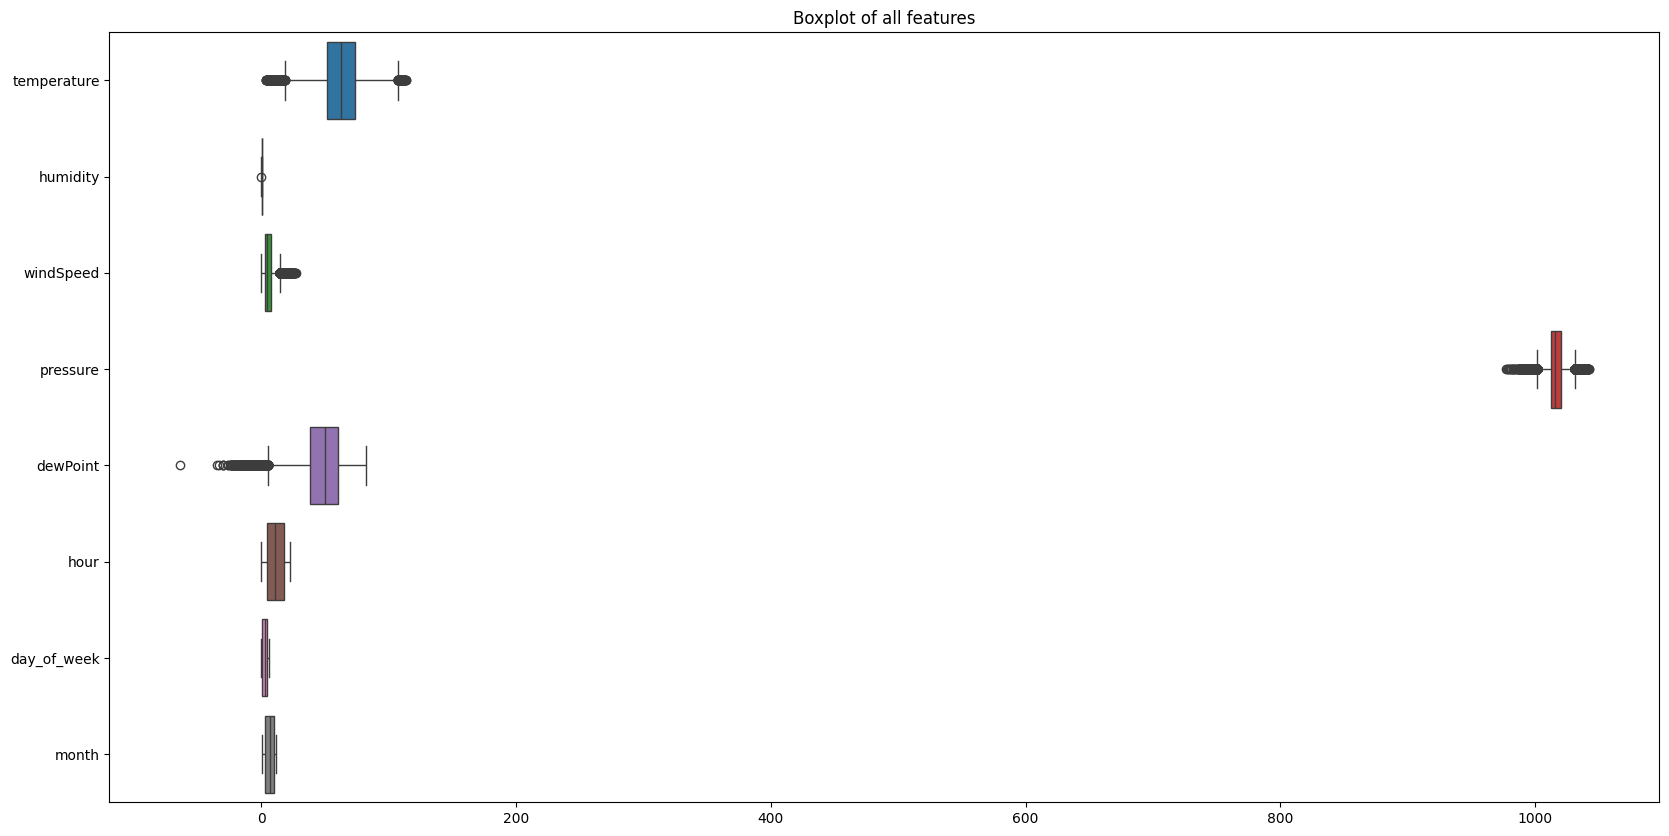

In [16]:
# Check outliers in all columns
plt.figure(figsize=(20, 10))
sns.boxplot(data=data.drop('demand_mwh', axis=1), orient='h')
plt.title('Boxplot of all features')
plt.show()

Anamoly and error Detection

In [17]:
data.columns

Index(['city', 'temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint',
       'demand_mwh', 'hour', 'day_of_week', 'month', 'season'],
      dtype='object')

In [18]:
iso_model = IsolationForest(contamination=0.01, random_state=42)
data['anomaly'] = iso_model.fit_predict(data[['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint']])


In [19]:
data['anomaly'].value_counts()

anomaly
 1    159195
-1      1609
Name: count, dtype: int64

Interpolating anamolies with median

In [20]:
anomalous_rows = data['anomaly'] == -1
features_cols = ['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint']
data.loc[anomalous_rows, features_cols] = np.nan 
for col in features_cols:
    medd = data[col].median()
    data[col].fillna(medd, inplace=True)


/tmp/ipykernel_10728/3108380180.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(medd, inplace=True)
/tmp/ipykernel_10728/3108380180.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [21]:
# Drop anaomaly column
data.drop('anomaly', axis=1, inplace=True)

In [22]:
# Aggregation: Compute weekly summary statistics

weekly_summary = data.groupby([pd.Grouper(freq='W'), 'city']).agg(
    temp_mean=('temperature', 'mean'),
    hum_mean=('humidity', 'mean'),
    wind_mean=('windSpeed', 'mean'),
    demand_sum=('demand_mwh', 'sum'),
    demand_mean=('demand_mwh', 'mean')
).reset_index()
weekly_summary

,timestamp,city,temp_mean,hum_mean,wind_mean,demand_sum,demand_mean
0,2018-07-01,la,69.018824,0.677647,4.138235,209005.0,12294.411765
1,2018-07-01,phoenix,87.090000,0.140000,3.357059,72914.0,4289.058824
2,2018-07-01,san diego,65.680588,0.721765,5.027647,31713.0,1865.470588
3,2018-07-01,san jose,69.973529,0.615882,5.289412,230370.0,13551.176471
4,2018-07-01,seattle,59.637647,0.866471,4.452353,16062.0,944.823529
...,...,...,...,...,...,...,...
973,2020-05-24,nyc,59.770408,0.585714,11.291633,215558.0,4399.142857
974,2020-05-24,philadelphia,60.945600,0.639600,8.653600,85439.0,3417.560000
975,2020-05-24,san antonio,80.392000,0.622800,5.544400,184901.0,7396.040000
976,2020-05-24,san diego,65.990612,0.678367,6.572653,81673.0,1666.795918


In [23]:
weekly_summary.to_csv('data/weekly_summary.csv', index=False)

In [26]:
data.head()

,city,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour,day_of_week,month,season
timestamp,,,,,,,,,,,
2018-07-01 07:00:00,la,65.45,0.79,4.23,1014.5,58.64,9353.0,7,6,7,Summer
2018-07-01 07:00:00,phoenix,86.82,0.16,4.30,1008.9,34.57,2764.0,7,6,7,Summer
2018-07-01 07:00:00,san diego,61.71,0.80,3.53,1015.9,55.47,1737.0,7,6,7,Summer
2018-07-01 07:00:00,san jose,67.78,0.60,6.36,1012.8,53.27,10653.0,7,6,7,Summer
2018-07-01 07:00:00,seattle,59.32,0.86,4.81,1022.1,55.21,774.0,7,6,7,Summer


In [24]:
data.to_csv('data/preprocessed_and_cleaned_data.csv', index=True)

# ENDED HERE
___________________________________________________________________________________